In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import rbf_kernel
from and_logic_generator import get_not_y

In [2]:
# we create 40 separable points
random_state = 2**3
x, y = make_blobs(n_samples=40, centers=2, random_state=random_state)

In [3]:
# fit the model, don't regularize for illustration purposes
model = svm.SVC(kernel='rbf', C=100, gamma='scale')
model.fit(x, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [4]:
x0_mean = x[:, 0].mean()
x0_min = x[:, 0].min() - x0_mean * 1.0
x0_max = x[:, 0].max() + x0_mean * 1.0
x1_mean = x[:, 1].mean()
x1_min = x[:, 1].min() - x1_mean * 1.0
x1_max = x[:, 1].max() + x1_mean * 1.0

In [5]:
x_subset = np.array([
    [2.5, -3.0],
    [2.5, 0],
    [10, -3],
    [2.5, 10],
    [5, 12],
    [10, 13],
    ], dtype=np.float32)
y_subset = model.predict(x_subset)
print(y_subset)

score = model.decision_function(x_subset)
print(score)

[1 1 1 0 0 0]
[ 0.41630871  0.76741434  0.55726688 -0.69484275 -0.9453134  -0.72791227]


In [6]:
y_sign = np.array([[-1 if yy == 0 else 1 for yy in y_subset]], dtype=np.float32).T

In [7]:
sup_x = model.support_vectors_ # 8x2
dual_alpha = model.dual_coef_ # 1x8
beta = model.intercept_
gamma = model._gamma

print('sup_x', sup_x.shape)
print('dual_alpha', dual_alpha.shape)
print('gamma', gamma)

print('x test', x_subset.shape)

sup_x (8, 2)
dual_alpha (1, 8)
gamma 0.04089030167538266
x test (6, 2)


In [8]:
def get_gradient_rbf(support_x, dual_alpha, input_x, gamma, rbf):
    grad_df = None
    for ww, xx in zip((2.0 * gamma * dual_alpha.T * rbf).T, input_x):
        grad_temp = -ww @ (support_x-xx)
        if grad_df is None:
            grad_df = grad_temp
        else:
            grad_df = np.vstack((grad_df, grad_temp))
    return grad_df


In [9]:
learning_rate = 1.0
x_star = np.array(x_subset)
y_sign = np.array([[-1 if yy == 0 else 1 for yy in y_subset]], dtype=np.float32).T
y_not = get_not_y(y_subset)
pred_x_star = model.predict(x_star)
inds_update = np.where(pred_x_star != y_not)[0]

x_stack = np.array([], dtype=np.float32)

epoch, max_epochs = 0, 100
while len(inds_update) > 0 and epoch < max_epochs:
    rbf = rbf_kernel(sup_x, x_star[inds_update], gamma)
    grad = get_gradient_rbf(sup_x, dual_alpha, x_star[inds_update], gamma, rbf)
    # x_update = x_star[inds_update] + learning_rate * grad
    x_update = x_star[inds_update] - y_sign[inds_update] * learning_rate * grad
    x_star[inds_update] = x_update

    pred_x_star = model.predict(x_star)
    inds_update = np.where(pred_x_star != y_not)[0]
    epoch = epoch + 1
    
    if len(x_stack) == 0:
        x_stack = x_update
    else:
        x_stack = np.vstack((x_stack, x_update))

print(f'Total epochs = {epoch}')

Total epochs = 100


In [10]:
print('x_test\n', x_subset)
pred_test = model.predict(x_subset)
print('pred_test\n', y_subset)

ad_pred = model.predict(x_star)
print('ad_pred\n', ad_pred)

x_test
 [[ 2.5 -3. ]
 [ 2.5  0. ]
 [10.  -3. ]
 [ 2.5 10. ]
 [ 5.  12. ]
 [10.  13. ]]
pred_test
 [1 1 1 0 0 0]
ad_pred
 [1 1 1 0 0 0]


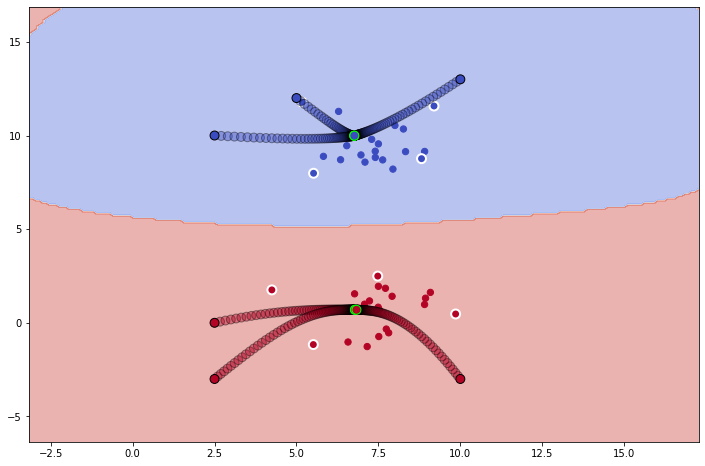

In [11]:
XX, YY = np.mgrid[x0_min:x0_max:200j, x1_min:x1_max:200j]
Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

figsize = np.array(plt.rcParams["figure.figsize"]) * 2
plt.figure(figsize=figsize.tolist())

plt.contourf(XX, YY, Z, cmap='coolwarm', alpha=0.4, zorder=1)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', edgecolor='face', s=40, zorder=2)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], c=y[model.support_], cmap='coolwarm', edgecolors='white', linewidths=2, s=80, zorder=10)

pred_test = model.predict(x_subset)
plt.scatter(x_subset[:, 0], x_subset[:, 1], c=pred_test, cmap='coolwarm', edgecolor='k', s=80, zorder=20)
plt.scatter(x_star[:, 0], x_star[:, 1], c=ad_pred, cmap='coolwarm', edgecolor='lime', s=80, zorder=20)

plt.scatter(x_stack[:, 0], x_stack[:, 1], c=model.predict(x_stack), cmap='coolwarm', edgecolor='k', s=80, zorder=10, alpha=0.4)

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)
plt.show()